# Covid-19 
1. Evolução Itália, Espanha e Portugal
2. Comparação entre China e Itália 
3. Número casos, Mortos e Recuperados Portugal e alguns países europeus 

As análises são atualizadas diariamente utilizando dados tratados pelo __Center for Systems Science and Engineering (CSSE) at Johns Hopkins University__ disponiveis em https://github.com/CSSEGISandData/COVID-19
Os dados diários são descarregados e combinados num ficheiro e atualizados online.

Procedimentos atualização dados:
```
git:
	cd ../covid-19;git reset --hard; git pull; 
	rm ../covid-19/csse_covid_19_data/csse_covid_19_daily_reports/bigfile.csv
	cd ../covid-19/csse_covid_19_data/csse_covid_19_daily_reports; awk '(NR == 1) || (FNR > 1)' *.csv > bigfile.csv
	cp -p "`ls -dtr ../covid_pt/datasets/*.csv | tail -1`" dados/covid_pt.csv
	cp -p "`ls -dtr ../covid-19/csse_covid_19_data/csse_covid_19_daily_reports/*.csv | tail -1`" dados/covid.csv
	#apaga primeira linha
	sed -i '1d' dados/covid.csv
	#insere cabs
	sed -i '1iProvince/State,Country/Region,Last Update,Confirmed,Deaths,Recovered,Latitude,Longitude' dados/covid.csv
	#Adicionar git
	git add .
	git commit -m "update"
	git push -u origin master
```

Análise desenvolvida por __Pedro Sobreiro__ e __António Moreira__ professores na Escola Superior de Desporto de Rio Maior e pode ser consultada em https://sobreiro.herokuapp.com/voila/render/analysis/Covid-19.ipynb

In [471]:
# storing and anaysis
import numpy as np
import pandas as pd

# visualization
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns 
import plotly.express as px

import warnings; 
warnings.simplefilter('ignore')

In [472]:
# importing datasets
full_table = pd.read_csv('https://raw.githubusercontent.com/pesobreiro/jupyternotebooks/master/dados/covid.csv',parse_dates=['Last Update'])


In [473]:
full_table.columns = ['Province/State', 'Country/Region', 'Date', 'Confirmed',
       'Deaths', 'Recovered', 'Latitude', 'Longitude']

In [474]:
full_table.Date=full_table['Date'].dt.date

In [475]:
# replacing Mainland china with just China
full_table['Country/Region'] = full_table['Country/Region'].replace('Mainland China', 'China')

# filling missing values with NA
full_table[['Province/State']] = full_table[['Province/State']].fillna('NA')

In [476]:
#full_table.drop_duplicates(subset=['Province/State','Country/Region', 'Date'], keep=False, inplace=True)

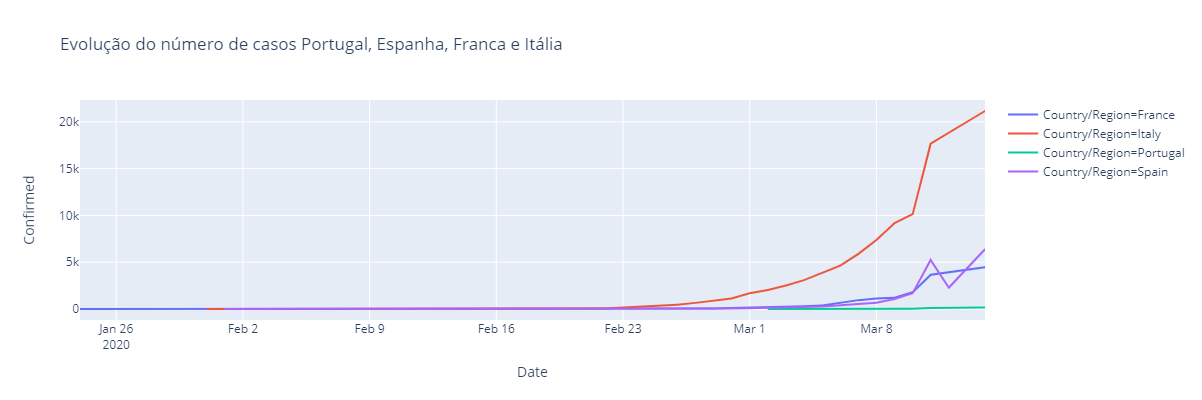

In [477]:
temp = full_table.loc[((full_table['Country/Region']=='Spain')| (full_table['Country/Region']=='Portugal')
                       |(full_table['Country/Region']=='France')| (full_table['Country/Region']=='Italy'))]

temp = temp.groupby(['Date', 'Country/Region'])['Confirmed', 'Deaths', 'Recovered'].max().reset_index()
#temp = full_table.groupby(['Date', 'Country/Region'])['Confirmed'].sum().reset_index().sort_values('Confirmed', ascending=False)
temp.sort_values(by=['Country/Region','Date'],inplace=True)

temp = temp.reset_index()


fig = px.line(temp, x="Date", y="Confirmed", color='Country/Region',height=400,width=1000,
             title='Evolução do número de casos Portugal, Espanha, Franca e Itália')
fig.show()

Existe uma quebra na fonte para os dados no dia 11 para Espanha que está reportado como menos do que no dia anterior

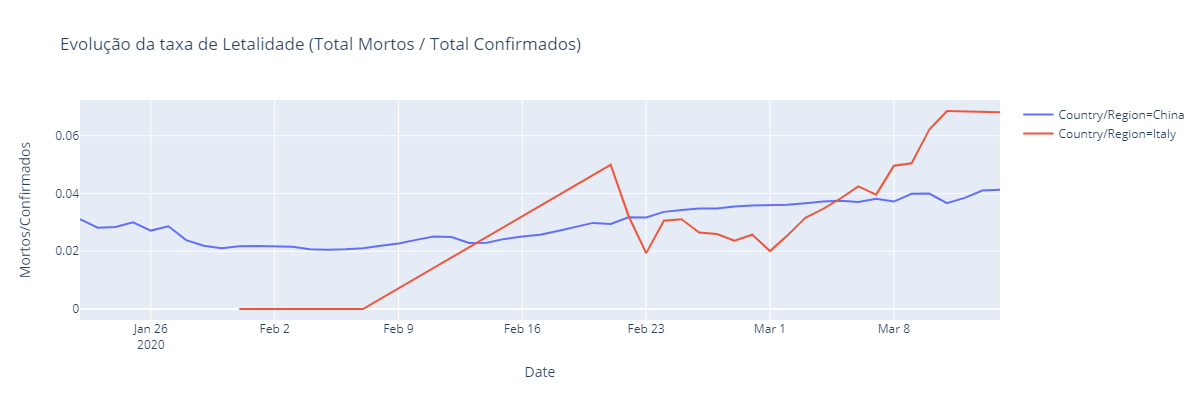

In [478]:
temp = full_table.loc[(full_table['Country/Region']=='Italy') | (full_table['Country/Region']=='China')]
temp = temp.groupby(['Country/Region', 'Date'])['Confirmed', 'Deaths', 'Recovered'].sum()

temp = temp.reset_index()
temp['Mortos/Confirmados'] = temp['Deaths']/temp['Confirmed']


fig = px.line(temp, x="Date", y="Mortos/Confirmados", color='Country/Region',height=400,width=1000,
             title='Evolução da taxa de Letalidade (Total Mortos / Total Confirmados)')
fig.show()

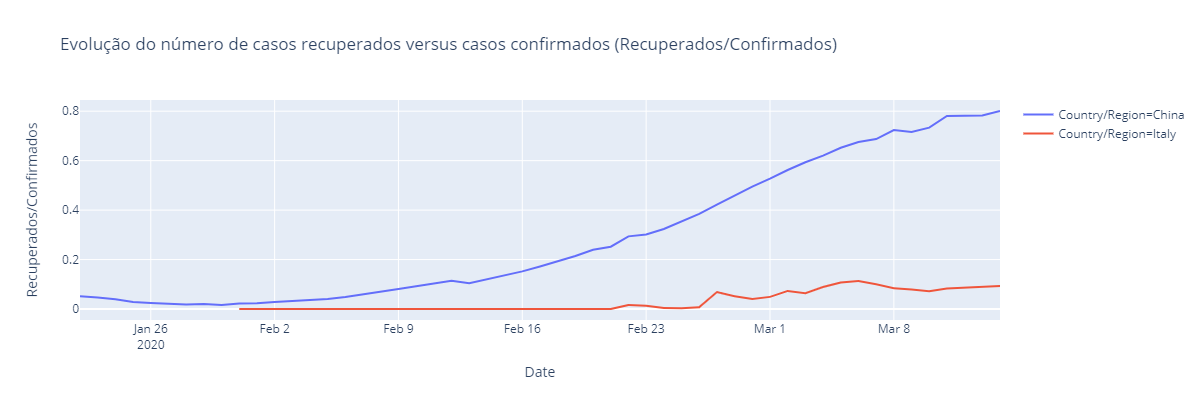

In [479]:
temp['Recuperados/Confirmados'] = temp['Recovered']/temp['Confirmed']

fig = px.line(temp, x="Date", y="Recuperados/Confirmados", color='Country/Region',  height=400,width=1000,
             title='Evolução do número de casos recuperados versus casos confirmados (Recuperados/Confirmados)')
fig.show()

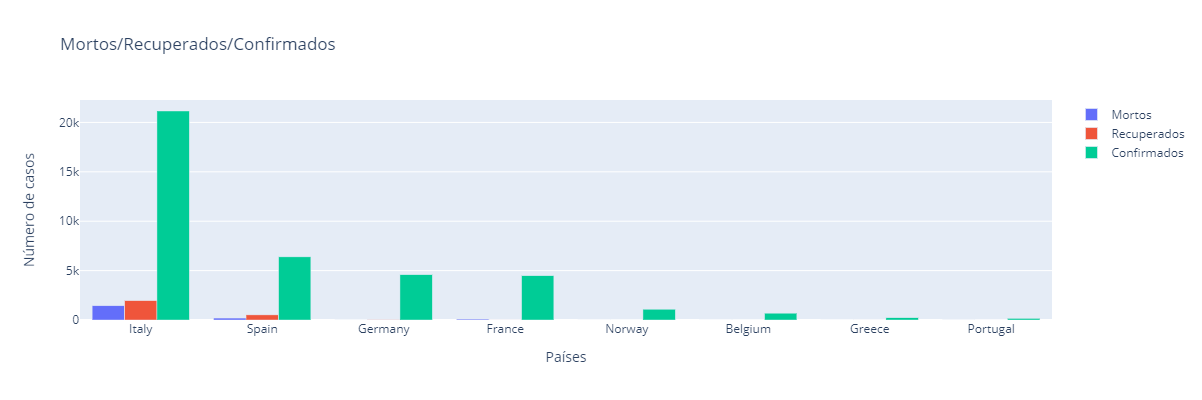

In [480]:
temp = full_table.loc[full_table.Date == full_table.Date.max()]
temp = temp.groupby(['Country/Region'])['Confirmed', 'Deaths', 'Recovered'].sum().sort_values('Confirmed',ascending=False)


europa = ['Italy', 'France', 'Germany', 'Spain', 'Belgium', 'Norway','Greece',  'Portugal']

temp=temp.reset_index()
temp=temp.loc[temp['Country/Region'].isin(europa)]


import plotly.graph_objects as go

layout = go.Layout(height=400,width=1000)

fig = go.Figure(data=[
    go.Bar(name='Mortos', x=temp['Country/Region'], y=temp['Deaths']),
    go.Bar(name='Recuperados', x=temp['Country/Region'], y=temp['Recovered']),
    go.Bar(name='Confirmados', x=temp['Country/Region'], y=temp['Confirmed']),
],layout=layout)

fig.update_layout(
    title="Mortos/Recuperados/Confirmados",
    xaxis_title="Países",
    yaxis_title="Número de casos",
)
fig.show()

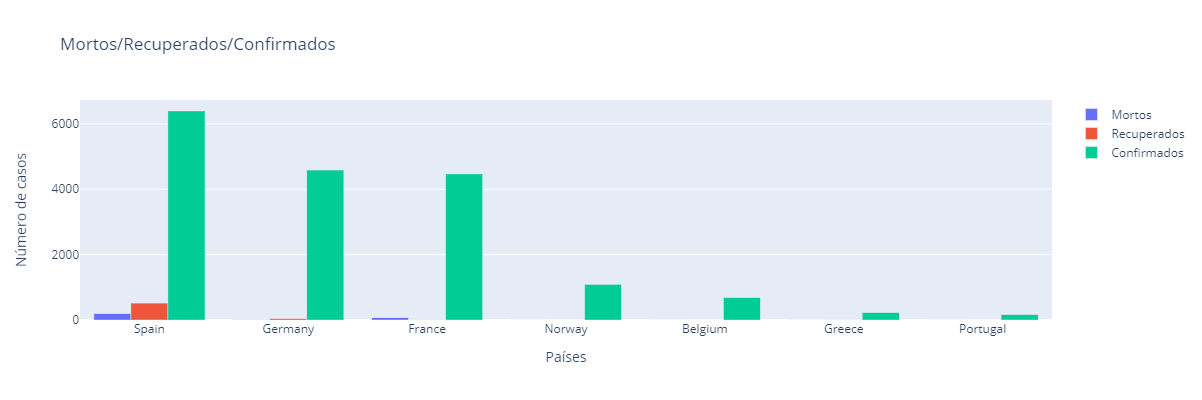

In [481]:
europa = [ 'France', 'Germany', 'Spain', 'Belgium', 'Norway','Greece',  'Portugal']
temp=full_table.loc[full_table.Date == full_table.Date.max()]
temp=temp.reset_index()
temp=temp.loc[temp['Country/Region'].isin(europa)]

layout = go.Layout(height=400,width=1000)

fig = go.Figure(data=[
    go.Bar(name='Mortos', x=temp['Country/Region'], y=temp['Deaths']),
    go.Bar(name='Recuperados', x=temp['Country/Region'], y=temp['Recovered']),
    go.Bar(name='Confirmados', x=temp['Country/Region'], y=temp['Confirmed']),
],layout=layout)

fig.update_layout(
    title="Mortos/Recuperados/Confirmados",
    xaxis_title="Países",
    yaxis_title="Número de casos",
)

fig.show()

## Casos portugal

```
git:
	cd ../covid_pt;git reset --hard; git pull
	cp -p "`ls -dtr ../covid_pt/datasets/*.csv | tail -1`" dados/covid_pt.csv
```

Dados obtidos em https://github.com/aperaltasantos/covid_pt

In [482]:
# importing datasets
dfPortugal = pd.read_csv('https://raw.githubusercontent.com/pesobreiro/jupyternotebooks/master/dados/covid_pt.csv',parse_dates=['date'])

In [483]:
dfPortugal=dfPortugal.fillna(0)

In [484]:
# dfPortugal.columns

In [485]:
dfPortugal.columns = ['data', 'casos_suspeitos', 'casos_suspeitos_novos', 'confirmados', 'confirmados_novos',
       'internados', 'internados_novos', 'cuidadosIntensivos', 'cuidadosIntensivos_novos', 'recuperados','recuperados_novos', 'mortos', 'mortos_novos']

In [486]:
temp = pd.melt(dfPortugal,id_vars='data',
               value_vars=['casos_suspeitos', 'confirmados', 'internados', 'cuidadosIntensivos', 'mortos'])

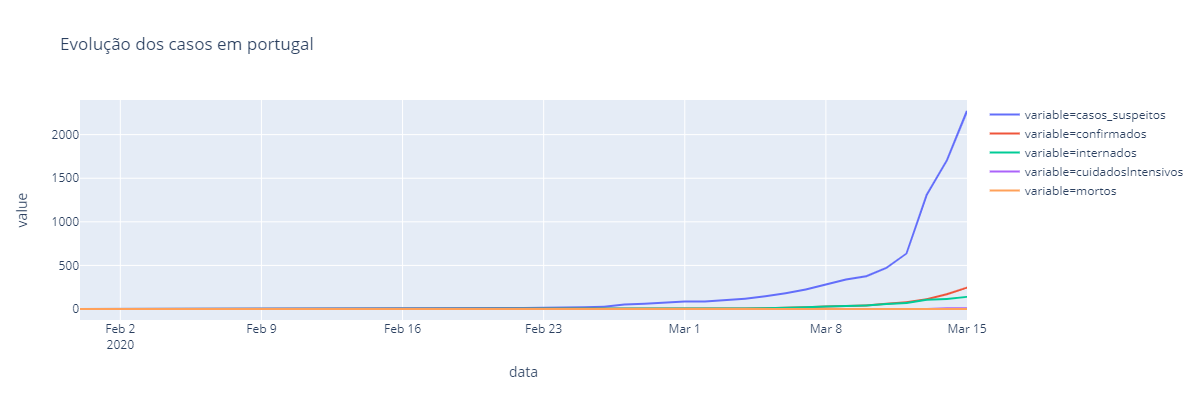

In [487]:
#temp['confirmed'] = temp['Recovered']/temp['Confirmed']

fig = px.line(temp, x="data", y="value", color = 'variable',height=400,width=1000,
             title='Evolução dos casos em portugal')
fig.show()

In [488]:
paises = ['Italy','Spain','France','Portugal','Germany','Switzerland']

In [489]:
temp = full_table.loc[((full_table['Country/Region']=='Spain')| (full_table['Country/Region']=='Portugal')
                       |(full_table['Country/Region']=='France')| (full_table['Country/Region']=='Italy')
                       | (full_table['Country/Region']=='Germany')| (full_table['Country/Region']=='Switzerland'))]

#temp = full_table

temp = temp.groupby(['Date', 'Country/Region'])['Confirmed', 'Deaths', 'Recovered'].max().reset_index()


In [490]:
#temp = temp.groupby(['Date'])['Confirmed', 'Deaths', 'Recovered'].sum().reset_index()

In [499]:
temp['dia'] = 0
i=0
for pais in paises:
    i=0
    for index, row in temp.loc[(temp['Country/Region']==pais)].iterrows():
        i = i + 1
        temp.at[index,'dia'] = i
    


In [498]:
#temp.loc[temp['Country/Region']=='Germany'].tail(100)

In [493]:
#,'Confirmed']=2128

In [494]:
temp.loc[((temp.Date == pd.to_datetime('2020-03-11'))&(temp['Country/Region']=='Spain')),'Confirmed'] = 2128

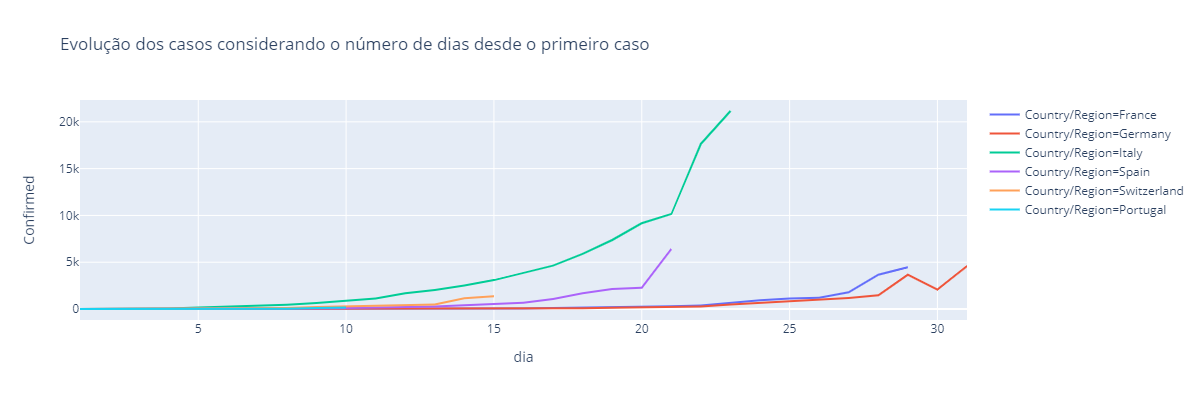

In [500]:
fig = px.line(temp, x="dia", y="Confirmed", color = 'Country/Region',height=400,width=1000,
             title='Evolução dos casos considerando o número de dias desde o primeiro caso')
fig.show()

França querer deslocar e Espanha está com um comportamento muito parecido com Itália. Todos os países tinham menos de 200 casos no décimo dia excepto Suiça e Itália.
Os dados foram corrigidos na Espanha 11.03.2020 na Espanha com a informação de https://www.mscbs.gob.es/profesionales/saludPublica/ccayes/alertasActual/nCov-China/documentos/Actualizacion_42_COVID-19.pdf

In [497]:
#europa = [ 'France', 'Germany', 'Spain', 'Belgium', 'Norway','Greece',  'Portugal']
#temp=full_table.loc[full_table.Date == full_table.Date.max()]
#temp=temp.reset_index()
#temp=temp.loc[temp['Country/Region'].isin(europa)]
#
#layout = go.Layout(height=400,width=1000)
#
#fig = go.Figure(data=[
#    go.Bar(name='Mortos', x=temp['Country/Region'], y=temp['Deaths']),
#    go.Bar(name='Recuperados', x=temp['Country/Region'], y=temp['Recovered']),
#    go.Bar(name='Confirmados', x=temp['Country/Region'], y=temp['Confirmed']),
#],layout=layout)
#
#fig.update_layout(
#    title="Mortos/Recuperados/Confirmados",
#    xaxis_title="Países",
#    yaxis_title="Número de casos",
#)
#
#fig.show()